In [1]:
import numpy as np
import pandas as pd
import random
import sklearn.preprocessing
import statsmodels.api as sm
from sklearn import datasets

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from tqdm import tqdm


## Step 0. 데이터 준비

본 튜토리얼에서 활용된 데이터는 King County, Washington State, USA의 부동산 가격 데이터입니다. 여러 변수를 활용해 타겟 변수인 부동산 가격을 예측하는 데이터입니다.

In [2]:
# 출처 : https://www.kaggle.com/datasets/shivachandel/kc-house-data
data = pd.read_csv('data/Housesales/kc_house_data.csv')

In [3]:
X = data.drop(['price', 'date', 'id'], axis=1)
columns = dict(zip(list(range(len(X.columns))), X.columns))
X = sklearn.preprocessing.normalize(X, axis=1)
y = data['price']

In [4]:
columns

{0: 'bedrooms',
 1: 'bathrooms',
 2: 'sqft_living',
 3: 'sqft_lot',
 4: 'floors',
 5: 'waterfront',
 6: 'view',
 7: 'condition',
 8: 'grade',
 9: 'sqft_above',
 10: 'sqft_basement',
 11: 'yr_built',
 12: 'yr_renovated',
 13: 'zipcode',
 14: 'lat',
 15: 'long',
 16: 'sqft_living15',
 17: 'sqft_lot15'}

## Step 1. 초기화

염색체의 각 유전자마다 난수를 생성하여, 해당 변수를 사용할 것인지 혹은 사용하지 않을 것인지에 해당하는 1 혹은 0의 이진값으로 변환합니다.

In [5]:
# Hyper Parameter
population_size = 8
cut_off = 0.8

* population_size : 한 세대에 몇개의 염섹체로 구성할 것인지를 정합니다.
* cut_off : cut_off가 높을수록 더 적은 유전자로 염색체를 초기화하게 됩니다.

In [6]:
def make_chromosome(X, population_size, cut_off):
    chromosome_list = []
    for chromosome in range(population_size):
        feature_random_number = []
        for feature in range(X.shape[1]):    
            if random.uniform(0,1) >= cut_off:
                feature_random_number.append(1)
            else:
                feature_random_number.append(0)
        chromosome_list.append(feature_random_number)
    return chromosome_list

In [7]:
chromosome_list = make_chromosome(X, population_size, cut_off)

In [8]:
chromosome_list

[[1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0],
 [0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
 [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
 [1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0],
 [0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]]

한 세대는 위와 같은 형태로 population_size에서 정한 수의 염색체 집합으로 구성되게 됩니다.

## Step2. 모델 학습

위에서 생성한 각 염색체를 이용하여 각각의 모델을 학습 시킵니다. 본 튜토리얼에서는 선형 회귀를 사용하며, 평가 지표로는 adjusted r squared 값을 사용하게 됩니다.

In [9]:
def train_chromosome(X, chromosome_list, metric='adjusted_r_squared'):
    score_list = []
    for chromosome in range(population_size):
        indices = [i for i,x in enumerate(chromosome_list[chromosome]) if x == 1]
        X_selected = sm.add_constant(X[:,indices])
        model = sm.OLS(y, X_selected).fit()
        
        if metric == 'adjusted_r_squared': 
            score = model.rsquared_adj
        score_list.append(score)
    return score_list

In [10]:
score_list = train_chromosome(X, chromosome_list, metric='adjusted_r_squared')

In [11]:
score_list

[0.22836795891166084,
 2.220446049250313e-16,
 0.49359149536212565,
 0.1794396315072393,
 0.06046181399206163,
 0.40790868536275593,
 0.4791892336552743,
 0.12499397754844144]

앞에서 구성한 한 세대를 구성하고 있는 염색체들 각각의 점수를 metric으로 정한 평가지표를 활용해 구하게 됩니다.

## Step3. 적합도 평가

Step 2의 모델 학습 단계에서 구해낸 점수를 활용하여 각 염색체의 적합도를 평가합니다. 만약 같은 성능을 보이는 염색체들이 있다면 더 적은 변수를 사용한 경우를 더 우수하게 평가합니다. 

각 염색체의 점수를 활용하여 가중치를 계산하며, 가중치는 부모로 선택 될 확률로 사용됩니다. 뛰어난 염색체일수록 부모로 선택 될 확률이 높습니다.

또한 가장 우수한 염색체는 교배 여부와 상관없이 다음 세대로 계승하게 되며, 이때 얼마나 많은 염색체를 다음 세대로 보낼 것인지 설정 가능합니다.

In [12]:
def evaluate_chromosome(score_list, chromosome_list, elitism = 1):
    seq = sorted(score_list, reverse=True) 
    rank = [seq.index(v) for v in score_list]
    score_for_weight = score_list - min(score_list)
    sum_score = sum(score_for_weight)
    weight = [(score / sum_score) for score in score_for_weight]
    feature_num = [sum(i) for i in chromosome_list]
    eval_result = pd.DataFrame([score_list, rank, weight, feature_num]).T
    eval_result.columns = ['score', 'rank', 'weight', 'feature_num']
    eval_result['rank'] = eval_result.loc[:, ['rank']].astype('int')
    eval_result['feature_num'] = eval_result.loc[:, ['feature_num']].astype('int')
    
    if elitism:
        elite = eval_result.drop_duplicates().sort_values(['rank', 'feature_num']).index[:elitism*2]
    else:
        elite = False
        
    return eval_result, list(elite)

elitism은 제일 우수한 염색체 중 몇 쌍을 다음 세대로 보낼 것인지를 결정하는 하이퍼 파라미터입니다. 여기서는 default 값은 1을 사용했으므로 염색체 1쌍, 즉 2개의 염색체를 다음 세대로 교배와 상관없이 보내게 됩니다.

In [13]:
eval_result, elite = evaluate_chromosome(score_list, chromosome_list)

In [14]:
eval_result

,score,rank,weight,feature_num
0,2.283680e-01,3,0.115691,4
1,2.220446e-16,7,0.000000,0
2,4.935915e-01,0,0.250052,4
3,1.794396e-01,4,0.090904,3
4,6.046181e-02,6,0.030630,2
5,4.079087e-01,2,0.206646,3
6,4.791892e-01,1,0.242756,5
7,1.249940e-01,5,0.063322,3


weight의 경우, 단순하게 score의 합에서 각 염색체의 score을 구한 비율을 사용 할 수도 있습니다. 

하지만 여기서는 한 세대의 score의 최솟값을 각각 score에서 뺀 뒤 비율을 계산했습니다. 

weight를 이렇게 구성한다면 score의 차이에 따른 weight의 차가 커지게 되며, 가장 성능이 좋지 않은 염색체는 아예 배제되고 성능이 좋은 염색체가 부모로 선택 될 확률이 늘어나게 됩니다.

In [15]:
elite

[2, 6]

elite의 경우 성능이 가장 좋았던 3번째 및 7번째 염색체가 선택되었습니다. 해당 염색체들은 다음 세대로 이어지게 됩니다.

## Step4. 부모 염색체 선택

위에서 계산한 가중치를 활용하여 부모를 선택하게 됩니다.

In [16]:
def select_parents(chromosome_list, eval_result):
    selected = np.random.choice(range(len(chromosome_list)), 2, p=eval_result['weight'], replace=False)
    parent_1, parent_2 = chromosome_list[selected[0]], chromosome_list[selected[1]]
    return parent_1, parent_2

In [17]:
parent_1, parent_2 = select_parents(chromosome_list, eval_result)

In [18]:
parent_1

[0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0]

In [19]:
parent_2

[0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]

가중치에 따라 랜덤하게 한 쌍의 염색체가 부모로 선택 되었습니다.

## Step5. 교배

Step4에서 선택된 부모들로 교배를 진행합니다. 부모의 유전 형질을 섞음으로써 더 우수한 염색체가 등장하도록 합니다. 이때 Crossover point는 각 염색체를 몇개의 구간으로 나눌 것인지를 결정하며, 0부터 n(유전자의 갯수)-1만큼의 범위를 설정 가능합니다.

또한 각 유전자마자 무작위로 변이할 확률을 부여합니다. 이와 같은 Exploration을 통해 local optima에 빠지지 않도록 돕습니다. 변이율이 높을수록 더 많은 변이가 일어나지만 수렴이 느려질 수 있습니다. 반면 변이율이 너무 낮다면 local optima에 빠질 위험이 큽니다.

In [20]:
crossover_num = 5
mutation_rate = 0.01

In [21]:
def crossover(parent_1, parent_2, crossover_num, mutation_rate):
    
    # make crossover point
    crossover_point = list(sorted(np.random.choice(range(1, len(parent_1)), crossover_num, replace=False)))
    crossover_point.append(len(parent_1))
    
    # split with crossover point
    parent_1_list = []
    parent_2_list = []
    for i, v in enumerate(crossover_point):
        if i == 0:
            parent_1_list.append(parent_1[:v])
            parent_2_list.append(parent_2[:v])
        else:
            parent_1_list.append(parent_1[crossover_point[i-1]:v])
            parent_2_list.append(parent_2[crossover_point[i-1]:v])
            
    # make new generations
    new_genes = []
    
    # crossover
    child_1, child_2 = [], []
    for j in range(crossover_num+1):
        p = random.uniform(0,1)
        if p <= 0.5 : 
            child_1 += parent_1_list[j]
            child_2 += parent_2_list[j]
        else:
            child_1 += parent_2_list[j]
            child_2 += parent_1_list[j]

    # mutation
    for k in range(len(child_1)):
        if random.uniform(0,1) <= mutation_rate:
            if child_1[k] == 0:
                child_1[k] = 1
            else:
                child_1[k] = 0

        if random.uniform(0,1) <= mutation_rate:
            if child_2[k] == 0:
                child_2[k] = 1
            else:
                child_2[k] = 0

    new_genes.append(child_1)
    new_genes.append(child_2)
        
    return new_genes

In [22]:
new_genes = crossover(parent_1, parent_2, crossover_num, mutation_rate)

In [23]:
new_genes

[[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0]]

이와 같이 Step4와 Step5를 반복하여 population size 만큼의 염색체를 만들게 되고, 다 만들어지면 한 세대가 완성되며 다시 Step 2로 돌아가서 종료 조건을 만족할 때까지 반복합니다.

---

---

# Run Algorithm

앞서서 알고리즘을 단계별로 살펴보았습니다. 이제 위와 같이 구현된 알고리즘을 활용하여 본격적으로 학습을 진행해보겠습니다.

In [24]:
# Hyper Parameter
population_size = 8
cut_off = 0.7
crossover_num = 17
mutation_rate = 0.03
elitism = 1
metric = 'adjusted_r_squared'
early_stopping = 50

In [25]:
generation_num = 1000
stag = 0
best_score = 0
history = []
elite_history = []

for i in tqdm(range(generation_num)):
    if i == 0:
        chromosome_list = make_chromosome(X, population_size, cut_off)
    else:
        chromosome_list = child_list
    
    score_list = train_chromosome(X, chromosome_list, metric)
    eval_result, elite = evaluate_chromosome(score_list, chromosome_list, elitism)
    child_list = [chromosome_list[elite[i]] for i in range(elitism*2)]
    
    for i in range(int((population_size/2) - elitism)):
        parent_1, parent_2 = select_parents(chromosome_list, eval_result)
        new_genes = crossover(parent_1, parent_2, crossover_num, mutation_rate)
        child_list += new_genes
    
    history.append(max(score_list)) # r-squared
    elite_history.append(chromosome_list[elite[0]])
    
    if max(score_list) == best_score:
        stag += 1
    else:
        stag = 0

    best_score = history[-1]
        
    if stag == early_stopping:
        break
        

 11%|████████▉                                                                      | 113/1000 [00:28<03:46,  3.92it/s]


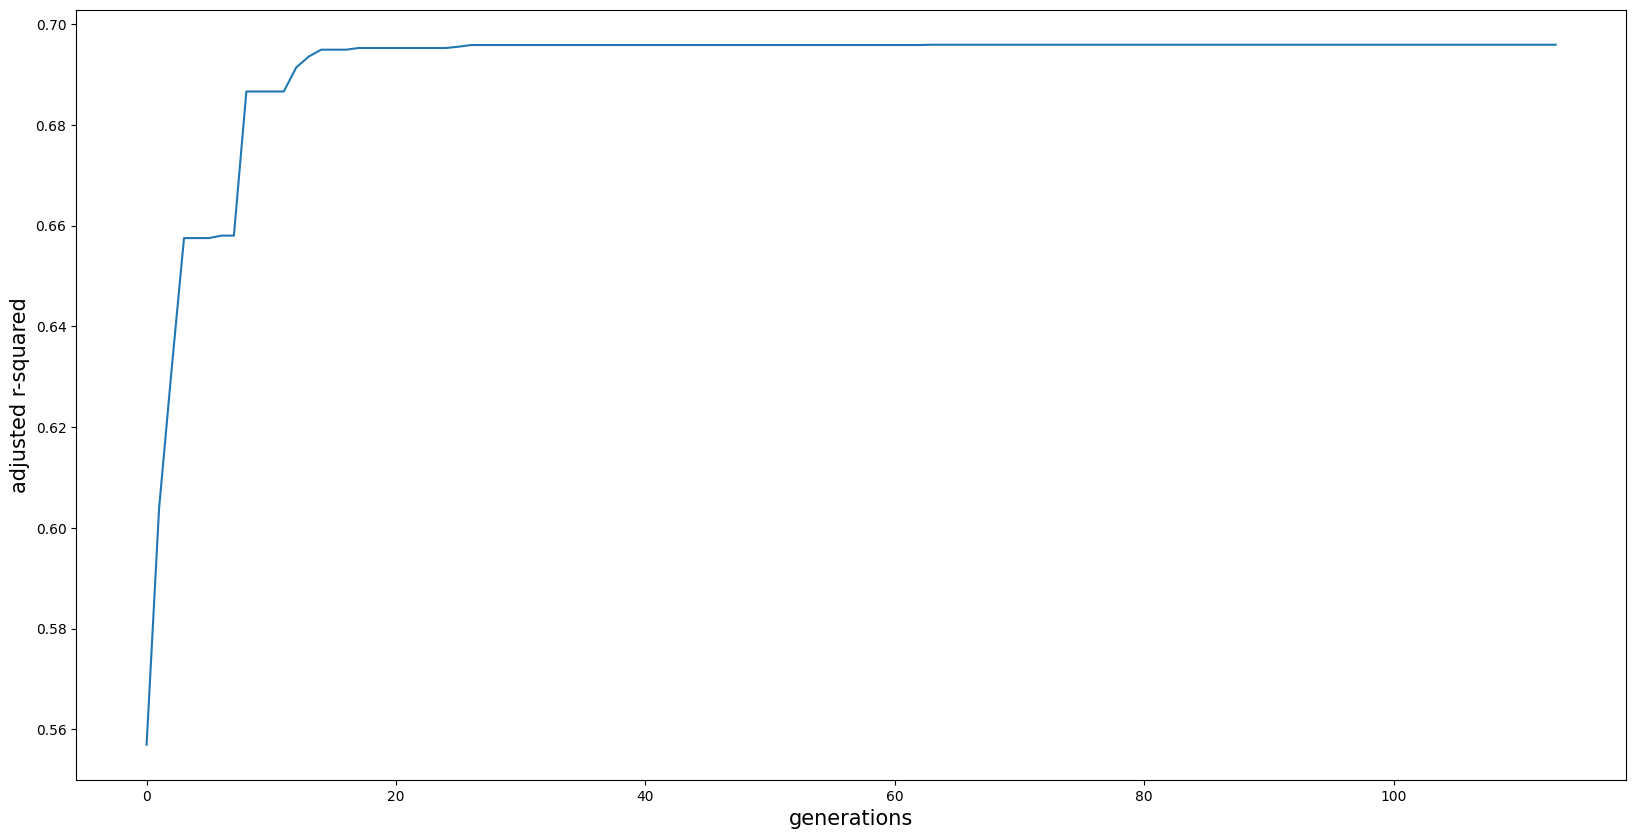

In [26]:
plt.figure(figsize=(20, 10))
plt.plot(history[0:])
plt.xlabel('generations', fontsize=15)
plt.ylabel('adjusted r-squared', fontsize=15)
plt.show()

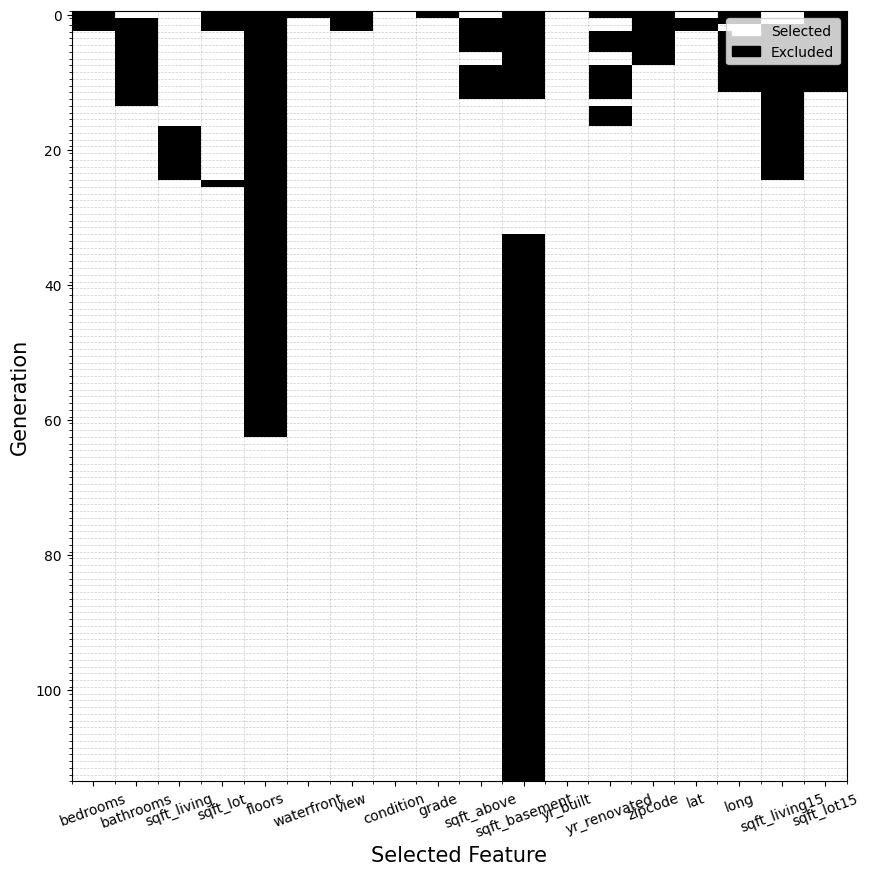

In [27]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(np.array(elite_history), cmap='gray', interpolation='none', aspect='auto')
# ax.set(xticks = range(len(columns)), xticklabels=columns.values(), fontsize=10)
ax.set_xticks(range(len(columns)))
ax.set_xticklabels(columns.values(), fontsize=10, rotation=20)
plt.xlabel('Selected Feature', fontsize=15)
plt.ylabel('Generation', fontsize=15)

minor_xticks = np.arange(-.5, len(columns))
minor_yticks = np.arange(-.5, len(history))
ax.set_yticks(minor_yticks, minor=True)
ax.set_xticks(minor_xticks, minor=True)
# ax.set_xticklabels(columns.values())

ax.grid(which = 'minor', color='black', linestyle='--', linewidth=0.5, alpha=0.2)

excluded = mpatches.Patch(color='black', label='Excluded')
selected = mpatches.Patch(color='white', label='Selected')
plt.legend(handles=[selected, excluded], prop={'size': 10})

plt.show()

113 세대에서 더 이상 좋은 자손이 발생하지 않아 학습이 멈추었습니다. 

하나의 변수를 제외한 모든 변수를 사용한 것을 확인할 수 있습니다. 

제외된 변수는 **sqft_basement**이며 해당 변수는 부동산 가격과 큰 관련이 없다고 해석 할 수 있습니다. 

## 평가지표 : rmse 

앞서 한 단계씩 차례대로 구현하며 평가지표로 adjusted r-squared 를 활용하여 변수 선택법을 진행했습니다. 이제 모듈화 된 코드를 통해 다른 평가지표인 RMSE로 모델을 학습시켜보겠습니다. 

여기서는 hyper parameter들은 cut_off를 제외하고 나머지는 기존에 설정된 default 값을 사용하겠습니다.

In [29]:
from model import genetic_algorithm
history, elite_history = genetic_algorithm(X, y, metric='rmse')

  7%|█████▍                                                                          | 68/1000 [01:02<14:10,  1.10it/s]


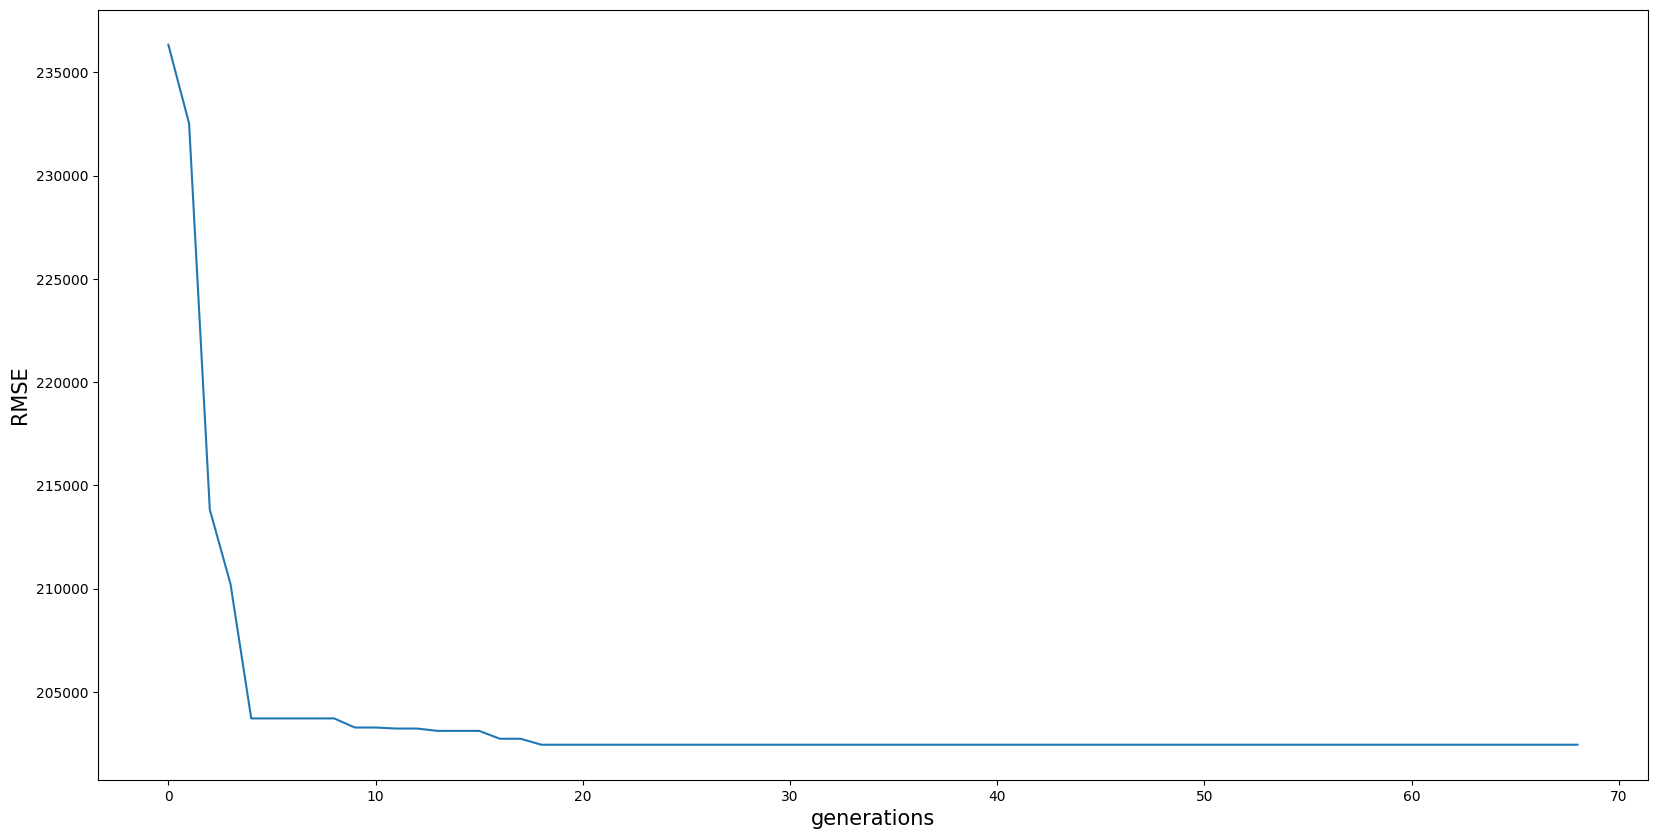

In [30]:
plt.figure(figsize=(20, 10))
plt.plot(history[0:])
plt.xlabel('generations', fontsize=15)
plt.ylabel('RMSE', fontsize=15)
plt.show()

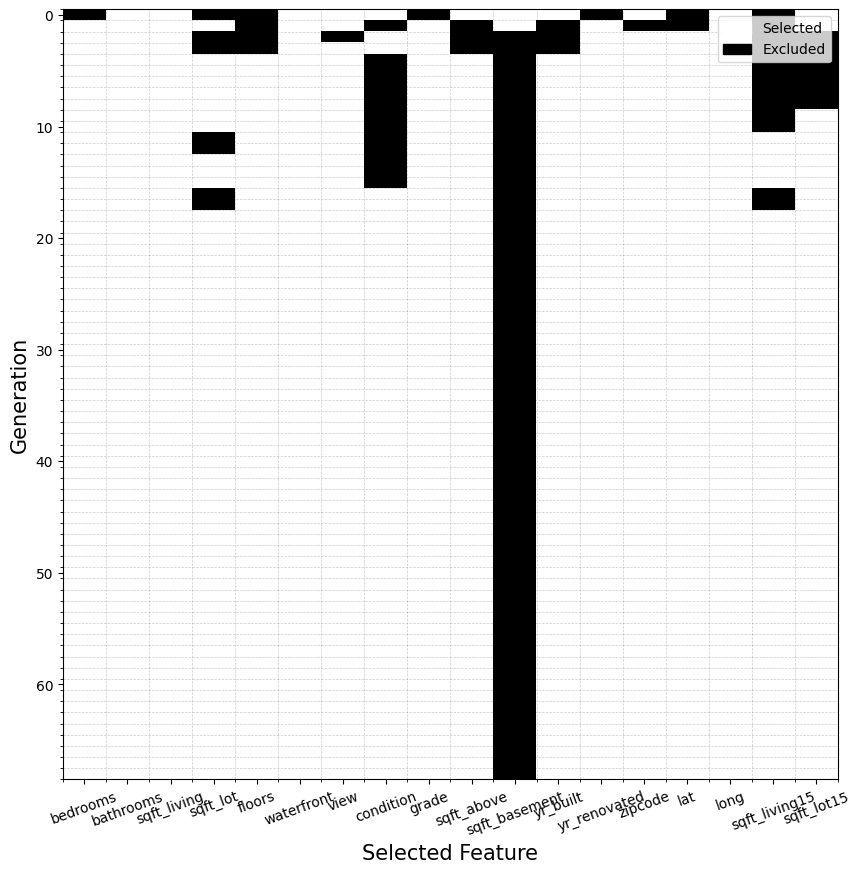

In [31]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(np.array(elite_history), cmap='gray', interpolation='none', aspect='auto')
# ax.set(xticks = range(len(columns)), xticklabels=columns.values(), fontsize=10)
ax.set_xticks(range(len(columns)))
ax.set_xticklabels(columns.values(), fontsize=10, rotation=20)
plt.xlabel('Selected Feature', fontsize=15)
plt.ylabel('Generation', fontsize=15)

minor_xticks = np.arange(-.5, len(columns))
minor_yticks = np.arange(-.5, len(history))
ax.set_yticks(minor_yticks, minor=True)
ax.set_xticks(minor_xticks, minor=True)
# ax.set_xticklabels(columns.values())

ax.grid(which = 'minor', color='black', linestyle='--', linewidth=0.5, alpha=0.2)

excluded = mpatches.Patch(color='black', label='Excluded')
selected = mpatches.Patch(color='white', label='Selected')
plt.legend(handles=[selected, excluded], prop={'size': 10})

plt.show()

평가지표로 adjusted r squared 값을 쓴 것과 같은 결과가 나왔지만, 수렴은 더 빠르게 됐습니다.

# Dataset : Diabates

이제 다른 데이터도 한번 시도해보겠습니다. 여기서 사용하게 될 데이터는 당뇨병 데이터로, 1년 후의 당뇨병 경과를 예측하는 것이 목적입니다. 

이전에 사용했던 부동산 가격 데이터에 비해 더 적은 변수의 수를 가지고 있습니다.

In [32]:
from sklearn.datasets import load_diabetes

diabetes = load_diabetes()
df = pd.DataFrame(diabetes.data, columns=diabetes.feature_names)
df["target"] = diabetes.target

X = df.drop(['target'], axis=1)
columns = dict(zip(list(range(len(X.columns))), X.columns))
X = sklearn.preprocessing.normalize(X, axis=1)
y = df['target']

In [33]:
columns

{0: 'age',
 1: 'sex',
 2: 'bmi',
 3: 'bp',
 4: 's1',
 5: 's2',
 6: 's3',
 7: 's4',
 8: 's5',
 9: 's6'}

### adjusted_r_squared

In [34]:
history, elite_history = genetic_algorithm(X, y, metric='adjusted_r_squared')

  6%|████▍                                                                           | 56/1000 [00:02<00:39, 23.79it/s]


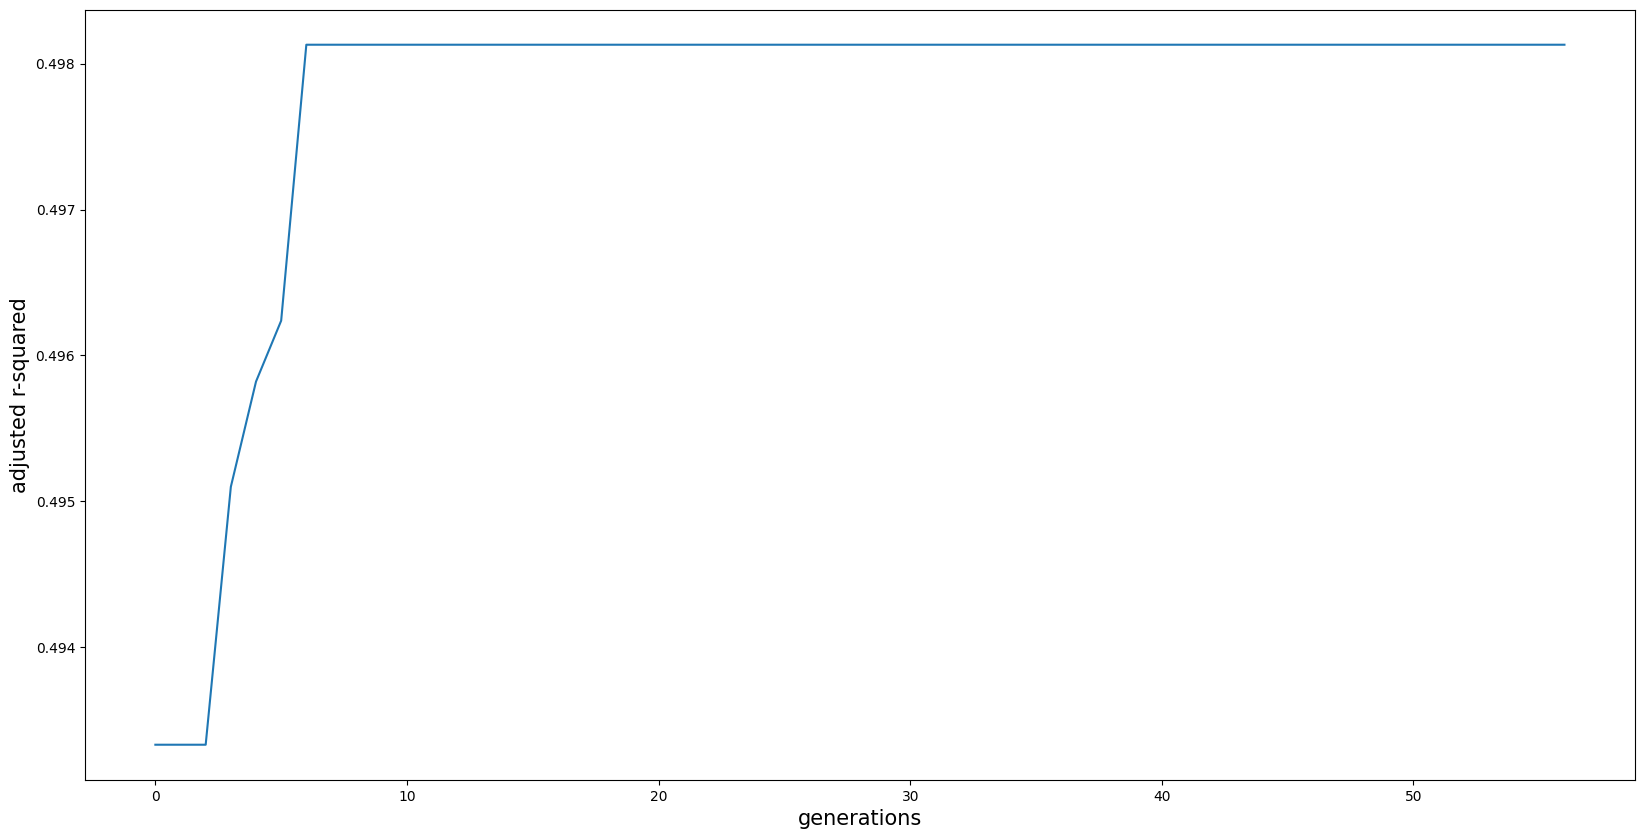

In [35]:
plt.figure(figsize=(20, 10))
plt.plot(history[0:])
plt.xlabel('generations', fontsize=15)
plt.ylabel('adjusted r-squared', fontsize=15)
plt.show()

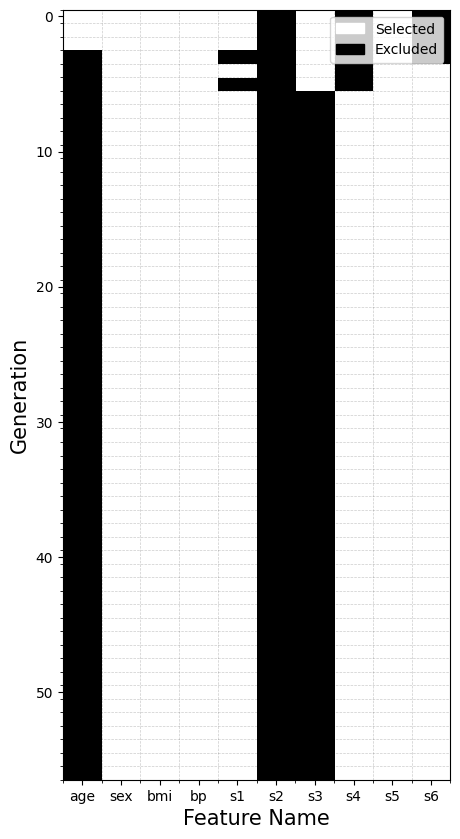

In [36]:
fig, ax = plt.subplots(figsize=(5, 10))
ax.imshow(np.array(elite_history), cmap='gray', interpolation='none', aspect='auto')
ax.set(xticks = range(len(columns)), xticklabels=columns.values())
plt.xlabel('Feature Name', fontsize=15)
plt.ylabel('Generation', fontsize=15)

minor_xticks = np.arange(-.5, len(columns))
minor_yticks = np.arange(-.5, len(history))
ax.set_yticks(minor_yticks, minor=True)
ax.set_xticks(minor_xticks, minor=True)
# ax.set_xticklabels(columns.values())

ax.grid(which = 'minor', color='black', linestyle='--', linewidth=0.5, alpha=0.2)

excluded = mpatches.Patch(color='black', label='Excluded')
selected = mpatches.Patch(color='white', label='Selected')
plt.legend(handles=[selected, excluded], prop={'size': 10})

plt.show()

앞서 살펴보았던 데이터에 비해 훨씬 빠르게 수렴했으며, 변수의 수가 적기 때문이라고 추측 해볼 수 있습니다. 3개의 변수(age, s2, s3)가 선택되지 않았습니다. RMSE로도 반복해보겠습니다.

### RMSE

In [37]:
history, elite_history = genetic_algorithm(X, y, metric='rmse')

  6%|█████                                                                           | 64/1000 [00:02<00:39, 23.85it/s]


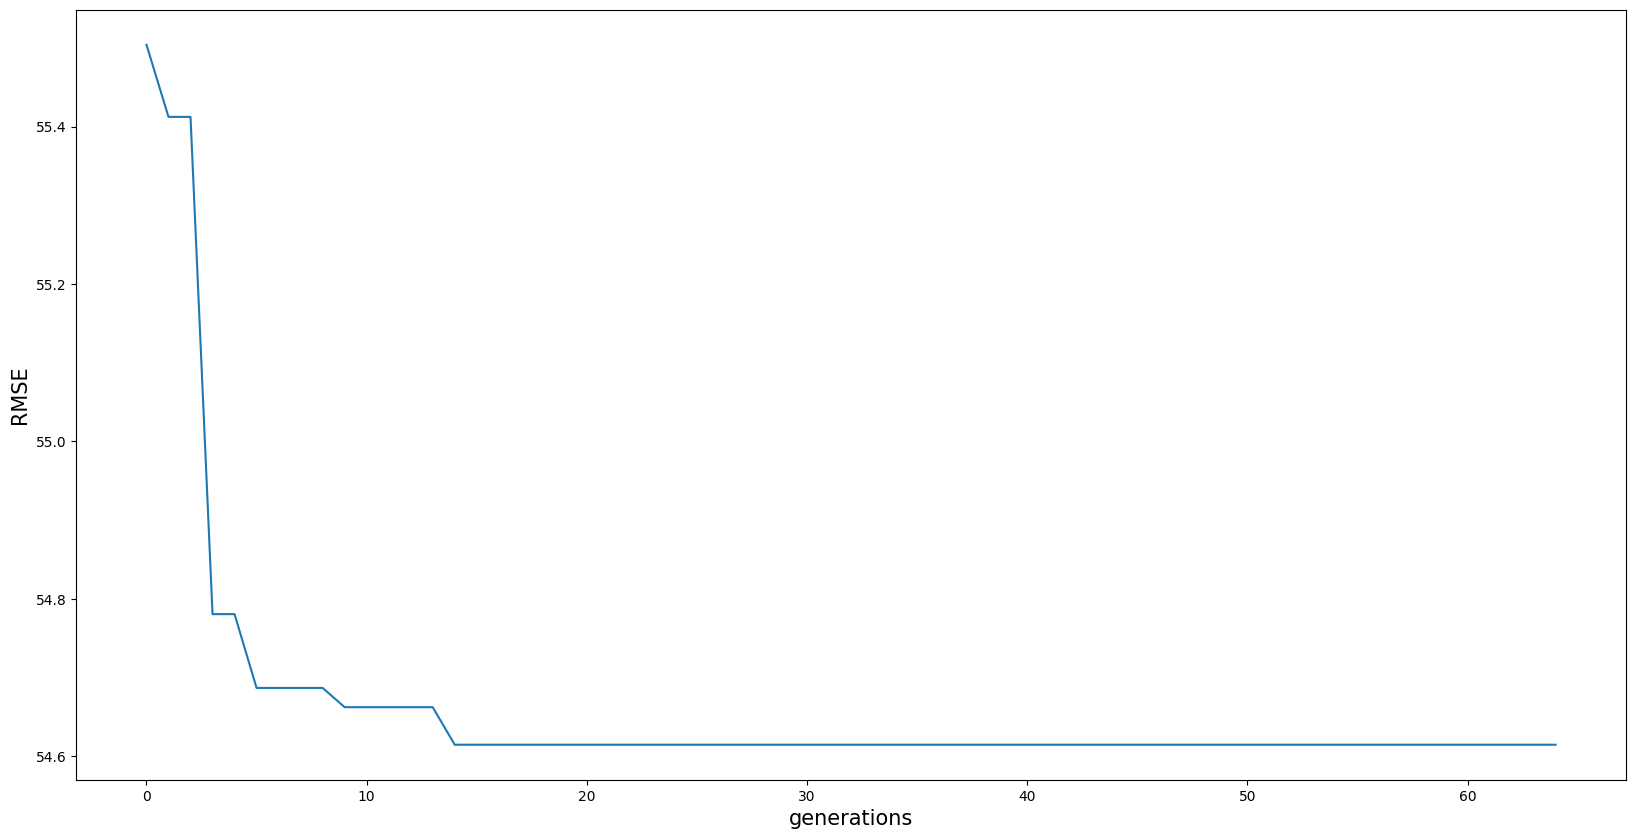

In [38]:
plt.figure(figsize=(20, 10))
plt.plot(history[0:])
plt.xlabel('generations', fontsize=15)
plt.ylabel('RMSE', fontsize=15)
plt.show()

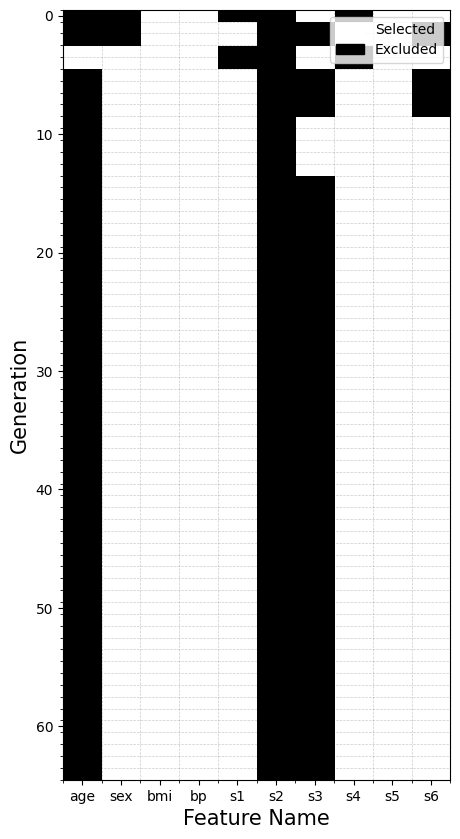

In [39]:
fig, ax = plt.subplots(figsize=(5, 10))
ax.imshow(np.array(elite_history), cmap='gray', interpolation='none', aspect='auto')
ax.set(xticks = range(len(columns)), xticklabels=columns.values())
plt.xlabel('Feature Name', fontsize=15)
plt.ylabel('Generation', fontsize=15)

minor_xticks = np.arange(-.5, len(columns))
minor_yticks = np.arange(-.5, len(history))
ax.set_yticks(minor_yticks, minor=True)
ax.set_xticks(minor_xticks, minor=True)
# ax.set_xticklabels(columns.values())

ax.grid(which = 'minor', color='black', linestyle='--', linewidth=0.5, alpha=0.2)

excluded = mpatches.Patch(color='black', label='Excluded')
selected = mpatches.Patch(color='white', label='Selected')
plt.legend(handles=[selected, excluded], prop={'size': 10})

plt.show()

마찬가지로 빠르게 수렴했으며 결과도 같습니다. 